<h1> Imports and Installs

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random

# For GNNs
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GraphNorm
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
import torch.nn as nn

<h1> Data Loading and Generation

Reptile for regression task using GNNs

Some common GNN datasets are here:
https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.GNNBenchmarkDataset

We will use a regression dataset with 19 regression targets from the paper:
“MoleculeNet: A Benchmark for Molecular Machine Learning”

For this implementation we focus on regressing only the Dipole moment

In [3]:
import torch
from torch_geometric.datasets import QM9

dataset = QM9(root='data/QM9')

In [4]:
# This function is based on https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

#Function to display properties of the dataset (it is not necessary for anything)
def display_graph_dataset_properties(dataset):
  print()
  print(f'Dataset: {dataset}:')
  print('====================')
  print(f'Number of graphs: {len(dataset)}')
  print(f'Number of features: {dataset.num_features}')
  print(f'Number of classes: {dataset.num_classes}')

  data = dataset[0]  # Get the first graph object.Ç

  print()
  print('Look at a sample graph of the dataset')
  print(data)
  print('=============================================================')

  # Gather some statistics about the first graph.
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

In [5]:
display_graph_dataset_properties(dataset)


Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19

Look at a sample graph of the dataset
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
# Transform the dataset into a list
dataset_list = []

for i in range(len(dataset)):
  dataset_list.append(dataset[i])

In [7]:
#Shuffle the dataset list
random.shuffle(dataset_list)
#Split into train and test
GRAPH_TRAIN = dataset_list[:int(np.floor(len(dataset_list)*0.9))]
GRAPH_TEST = dataset_list[int(np.floor(len(dataset_list)*0.9)):]

<h1> Neural Network Model

In [8]:

class GNN(torch.nn.Module):
    def __init__(self, input_dim=11, hidden_dim=64, output_dim=1):
        super(GNN, self).__init__()

        #Hidden Layers
        self.hidden1 = GraphConv(input_dim, hidden_dim)
        self.hidden2 = GraphConv(hidden_dim, hidden_dim)
        self.hidden3 = GraphConv(hidden_dim, output_dim)
        self.norm = GraphNorm(hidden_dim)

        #Activation Function
        self.relu = nn.ReLU()

        

    def forward(self, input_x, edge_index, batch):
      
        #Standard forward
        x = self.hidden1(input_x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden2(x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden3(x,edge_index)
        x = self.relu(x)

        #Global mean pool across batches
        x = global_max_pool(x, batch)

        
        return x


<h1> Helper functions

In [9]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = GNN()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,graph,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, graph, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, graph)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,graph,store_train_loss_meta):
    loss = evaluation(new_model, graph)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, graph, item = True):
    # Make model prediction
    prediction = new_model(graph.x,graph.edge_index,graph.batch)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,graph.y[:,task:task+1]).item()
    else:
      loss = criterion(prediction,graph.y[:,task:task+1])
    return loss

def training(model, graph, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, graph, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Reptile

In [10]:
#Define important variables
epochs = int(5000) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=100 # how many epochs should we wait to print the loss
lr_k=0.0005 # Internal learning rate
k=5 # Number of internal updates for each task
number_of_tasks=5
# Initializations
initialization_to_store_meta_losses()
model = GNN()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [11]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine graph (Task from training data)
    graph = random.sample(GRAPH_TRAIN, 1)
    task = random.randint(0, number_of_tasks-1)

    # Update model predefined number of times based on k
    new_model = training(model, graph[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,graph[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the graph from the test data
    graph = random.sample(GRAPH_TEST, 1)
    test_set_validation(model,new_model,graph[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

<ipython-input-9-6e1b143169bc>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameter.grad = torch.tensor(torch.zeros_like(parameter))


Epochh : 0, Average Train Meta Loss : 72.7740249633789, Average Test Meta Loss : 0.017190132290124893
Epochh : 100, Average Train Meta Loss : 15.25436590587679, Average Test Meta Loss : 25.147766204440167
Epochh : 200, Average Train Meta Loss : 14.43057369909677, Average Test Meta Loss : 18.02291684226469
Epochh : 300, Average Train Meta Loss : 13.305248623607456, Average Test Meta Loss : 15.716632743983368
Epochh : 400, Average Train Meta Loss : 13.330345415573051, Average Test Meta Loss : 14.901787921446205
Epochh : 500, Average Train Meta Loss : 12.746084111973763, Average Test Meta Loss : 14.022030824741831
Epochh : 600, Average Train Meta Loss : 12.606978094951312, Average Test Meta Loss : 13.521274447877877
Epochh : 700, Average Train Meta Loss : 11.823326580439131, Average Test Meta Loss : 12.662566294864025
Epochh : 800, Average Train Meta Loss : 11.422697448101626, Average Test Meta Loss : 12.315085406180676
Epochh : 900, Average Train Meta Loss : 11.393100621130205, Average T

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

Text(0.5, 0, 'k shots')

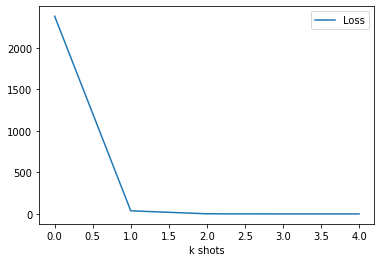

In [12]:
task = random.randint(0, number_of_tasks-1)
graph = GRAPH_TEST[0] 
k_shot_updates = 5
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, graph, lr_k, shots)
    train_set_evaluation(new_model,graph,store_train_loss_meta) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

Step: 0, Error: 3514.2941369628907, Var: 557692.8285727118
Step: 1, Error: 153.8470262516127, Var: 42812.86282452601
Step: 4, Error: 17.8077134375881, Var: 1898.561007396184


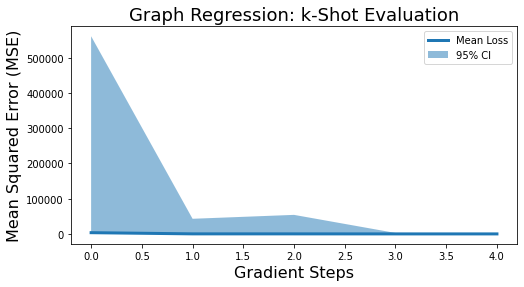

In [13]:
graph_type = "conv"

num_evals = 100

all_losses = []
for test_eval in range(num_evals): 

    graph = GRAPH_TEST[test_eval] 
    k_shot_updates = 5
    initialization_to_store_meta_losses()
    for shots in range(k_shot_updates):
        new_model = training(model, graph, lr_k, shots)
        train_set_evaluation(new_model,graph,store_train_loss_meta) 
    all_losses.append(np.array(store_train_loss_meta))

# plt.plot(store_train_loss_meta,label = 'Loss')
# plt.legend()
# plt.xlabel('k shots')


all_losses = np.array(all_losses)
np.save(f"reptile_graph_{graph_type}_k.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(len(mean_loss)))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
# to avoid having MSE < 0
truncated_error = np.clip(y-ci, a_min=0, a_max=None)
ax.fill_between(x, truncated_error, (y+ci), alpha=.5,label=f"95% CI")

ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Graph Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig(f"graph_reg_{graph_type}_kshot.png")

analysis_steps = [0, 1, k_shot_updates-1]
for analysis_step in analysis_steps: 
    print(f"Step: {analysis_step}, Error: {mean_loss[analysis_step]}, Var: {ci[analysis_step]}")